In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import savReaderWriter
from scipy import stats
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn import tree
import statsmodels.api as sm
from statsmodels.formula.api import ols
import time
%matplotlib inline

# A brief background on the dataset

This dataset was taken from a 2017 Pew Research Center Science and News survey. Questions revolve around broad views of science and news as well as where indivduals source their news information. Surveyors were asked to identify between Republican, Democrat, Independent, or something else. For the purposes of this model, I have limited the data to only those that identified as Republican or Democrat. The Random Forest model performed quite poorly when it had to classify between all 4 options (~50% accuracy across 10 cv folds). This is intuitive as a broad range of political positions can be expressed as Independent, something else, and no answer. Therefore the models are only classifying political party among those who identify as either Republican or Democrat.

In [58]:
#load survey data

with savReaderWriter.SavReader('Data/Dataset - 2017 Pew Research Center Science and News Survey (2017).sav') as reader:
    data = reader.all()
    


#load metadata, extract variable names, convert from bytes to utf-8

with savReaderWriter.SavHeaderReader('Data/Dataset - 2017 Pew Research Center Science and News Survey (2017).sav') as header:
    metadata = header.all()
    variables = metadata.varNames

for i in range(len(variables)):
    variables[i] = variables[i].decode('utf-8')


#add variables to data and convert to dataframe, remove those with missing values from outcome variable (party)

pew_df = pd.DataFrame(data)
pew_df.columns = variables
pew_df = pew_df.loc[(pew_df['PARTY'] != -1) & (pew_df['PARTY'] != 4) & (pew_df['PARTY'] != 3)]

Many of the questions in the survey include open-ended questions that were then coded into categories, because these variables can have dozens of distinct categories they will not provide much info for our model. 

In [59]:
#Loop through all vars, print those with more than 10 unique answers and add to a drop list

drop_vars = []

for var in pew_df.columns:
    column = pew_df[var]
    if column.nunique() > 10:   
        drop_vars.append(var)
        print(var)
        print(column.nunique())

CaseID
2530
HOBBY2_1
34
HOBBY2_2
27
HOBBY2_3
16
GREATPAST_OE1
52
GREATPAST_OE2
40
GREATPAST_OE3
27
GREATFUTURE_OE1
53
GREATFUTURE_OE2
45
GREATFUTURE_OE3
35
FAKE_OE1
29
DISAG_OE1
31
DECIS_OE1
31
DECIS_OE2
18
weight
1248
tm_start
2506
tm_finish
2507
duration
290
ppcm0160
31
IND1
23
PPINCIMP
21
AGE
72


We will drop the values above except for CaseID, weight, duration, PPINCIMP, and age. These values are ordinal and may provide useful information for the model.

In [60]:
# Remove ordinal values from drop list

for var in ['CaseID', 'weight','duration', 'PPINCIMP', 'AGE']: drop_vars.remove(var)

In [61]:
# Drop remaining variables in drop list from df

pew_df.drop(drop_vars, 1, inplace=True)

Next let's invesitgate any missing values in the dataset.

In [62]:
#Loop through all vars, print those with null values 

drop_vars = []

for var in pew_df.columns:
    column = pew_df[var]
    if column.isnull().sum()/len(column) > 0:   
        drop_vars.append(var)
        print(var)
        print('% missing = ' + str(column.isnull().sum()/len(column)*100))

FAKE_OE2
% missing = 99.84189723320158
FAKE_OE3
% missing = 99.96047430830039
DISAG_OE2
% missing = 99.60474308300395
DISAG_OE3
% missing = 99.9209486166008
DECIS_OE3
% missing = 99.72332015810277
TOPICMOST
% missing = 0.1976284584980237
SCIWHY_f
% missing = 76.95652173913044
SNSFREQ
% missing = 29.40711462450593
FOLLOW
% missing = 29.40711462450593
FOLLOWANTI
% missing = 29.40711462450593
SNSSCI
% missing = 29.40711462450593
SNSCLICK
% missing = 44.34782608695652
SNSSCIIMP
% missing = 44.34782608695652
SNSPOST_a
% missing = 44.34782608695652
SNSPOST_b
% missing = 44.34782608695652
SNSPOST_c
% missing = 44.34782608695652
SNSPOST_d
% missing = 44.34782608695652
SNSPOST_e
% missing = 44.34782608695652
SNSPOST_f
% missing = 44.34782608695652
SNSPOST_g
% missing = 44.34782608695652
SNSPOST_h
% missing = 44.34782608695652
SNSPOST_i
% missing = 44.34782608695652
SNSPOST_j
% missing = 44.34782608695652
SNSPOST_Refused
% missing = 44.34782608695652
SNSCHECK1_a
% missing = 83.83399209486167
SNS

In [63]:
#Because the variables above all have large amounts of missing values, these will be dropped
pew_df.drop(drop_vars, 1, inplace=True)

We still have a very large number of variables, we need a method of ordering which variables contain the most variance in our outcome variable. Because most of our variables contain more than 2 categories, doing T-tests would be clunky and innapropriate. We can conduct one-way ANOVAs on all our variables and rank them by F-statistic to see which variable contain the most variance. Because this is going to be computationally intensive with >200 variables, I will do these ANOVAs using a sample of the original data.

In [64]:
# Get sample

pew_sample = pew_df.sample(n=1000, random_state=1)

In [65]:
# Create list of dependent vars

x_list = list(pew_df.columns.drop('PARTY'))
for var in ['CaseID', 'weight','duration', 'PPINCIMP', 'AGE']: x_list.remove(var)

In [66]:
# Loop through x_list and conduct One-Way Anova across the groups in each var for party

# Create lists to save data

F = []
p = []
problem_vars = []

for var in x_list:
    
    # Create a string of the model for each ANOVA with the form 'PARTY ~ variable'
    
    try:
        mod_str = 'PARTY ~ ' + var
        mod = ols(mod_str, data=pew_sample).fit()
        aov_table= sm.stats.anova_lm(mod, typ=1)
        F.append(aov_table['F'][0])
        p.append(aov_table['PR(>F)'][0])
    except:
        problem_vars.append(var)
    

In [67]:
#Save results of anova in df with variable names

aov_res = pd.DataFrame(x_list, columns=['var'])
aov_res['F'] = F
aov_res['p-value'] = p 
aov_res.sort_values(by='F', ascending=False, inplace=True)

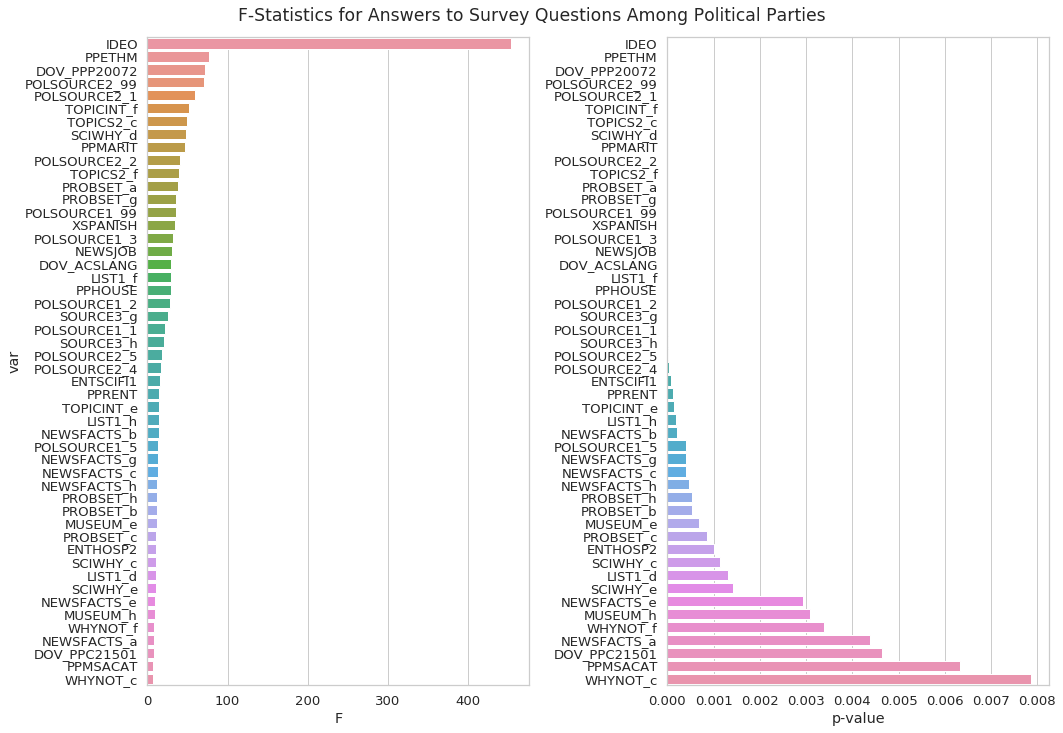

In [68]:
# Create plot of top 50 variables ordered by F-statistic

plt.figure(figsize=(15,10))
sns.set(font_scale=1.2, style='whitegrid')

plt.subplot(1,2,1)
sns.barplot(x='F', y='var', data=aov_res[:50])

plt.subplot(1,2,2)
sns.barplot(x='p-value', y='var', data=aov_res[:50])
plt.ylabel('')

plt.suptitle('F-Statistics for Answers to Survey Questions Among Political Parties', y=1.02)
plt.tight_layout()
plt.show()

Let's include these top features in our model as well as these ordinal features we found earlier. Because these variables are all nominal-categorical, we need to convert them to object data-types and then get dummy values.

In [69]:
# Save dependent variable names

features = aov_res[:50]['var']

In [70]:
# Convert to object dtype

for var in features:
    pew_df.loc[:,var] = pew_df[var].astype('O')

In [71]:
# Split data for modelling

X = pew_df[features]
X = pd.get_dummies(X)
X.join(pew_df.loc[:,('weight','duration', 'PPINCIMP', 'AGE')])
Y = pew_df['PARTY'].astype(str)

# Random Forest Classifier

In [84]:
# Create Random Forest Model and time it

start_time = time.time()

rfc = ensemble.RandomForestClassifier(n_estimators=200)
print('CV scores = ' + str(cross_val_score(rfc, X, Y, cv=10)))

print("\nThe RFC took %s seconds to run" % (time.time() - start_time))

CV scores = [0.86220472 0.86220472 0.83794466 0.84980237 0.88142292 0.84189723
 0.81818182 0.84980237 0.83730159 0.82936508]

The RFC took 8.261245727539062 seconds to run


# Decision Tree Classifier

In [86]:
# Create Decision Tree Classifier and time it

start_time = time.time()

dtc = tree.DecisionTreeClassifier()
print('CV scores = ' + str(cross_val_score(dtc, X, Y, cv=10)))

print("\nThe Decision Tree Classifier took %s seconds to run" % (time.time() - start_time))

CV scores = [0.79527559 0.77952756 0.75889328 0.76284585 0.78656126 0.76679842
 0.75889328 0.77470356 0.78968254 0.73015873]

The Decision Tree Classifier took 0.4155154228210449 seconds to run


# Summary

While the Random Forest Classifer (RFC) was about 5% more accurate than the Decision Tree Classifier (DTC), the DTC took much less time. With very large datasets, the tradeoff in accuracy should be carefully considered with the increase in computation time.